# Sheet 07

In [53]:
from numpy.typing import NDArray  # trying to be typesafe
import numpy as np  # needed all over the place
import scipy
from scipy.stats import skew
from IPython.display import HTML # in line animations

import os   # file and file path

from itertools import count
import pandas as pd
import matplotlib.pyplot as plt  # for plots

from matplotlib import colors  # not quite sure what fore
from matplotlib.ticker import PercentFormatter  # also not sure, maybe animation..?
from matplotlib.animation import FuncAnimation, FFMpegWriter  # for animations

##### Markov Chain - Monte Carlo  - Metropolis importance Sampling

In [54]:
def initiate_positions_on_grid(
            num_particles: int,
            box: tuple [float, float],

    ) -> np.ndarray:
    """
    Initializes 2D positions on a Grid with even spacing.

    Parameters:
        
        n_particles:(int)
                -> number of particles
        
        box:(tuple[number,number]) 
                -> box size (in [nm])
        
    Return:
        (NDArray[float, shpae=(dimension, number of particles)])
                -> list of vectors of positons that are aranged on a grid
    """
    grid_sections = int(np.ceil(np.sqrt(num_particles)))  # find the number of colums & rows
    # even spacing
    x_spacing = box[0]/grid_sections 
    y_spacing = box[1]/grid_sections
    print("x_spacing:",x_spacing)
    print("y_spacing:",y_spacing)
    # makes grid coordinates
    x, y= np.meshgrid(
        np.arange(grid_sections) * x_spacing, 
        np.arange(grid_sections) * y_spacing
    )        # constants
    x= x.flatten()[:num_particles]+ x_spacing/2
    y= y.flatten()[:num_particles]+ y_spacing/2
    positions= np.linalg.matrix_transpose(np.array([x,y]))
    print("init positions: type",type(positions),"size",np.shape(positions))  
    return positions 

In [55]:
def boundry_conditions(
        rel_vector:np.ndarray,
        box: tuple
) -> np.ndarray:
    """ Determines the position of a vector under boundry conditions.

    Parameters:

    Returns:
    """
    for dim in range(len(box)):
        rel_vector[:,dim] -= box[dim] * np.round(rel_vector[:,dim] / box[dim])
    return rel_vector

def relative_distnace(
        x_1: np.ndarray, 
        x_2: np.ndarray, 
        box: tuple
):
    """
    Determines the minimum relative distance over the boundry conditions

    Parameters:
        x_1: (NDArray)
            position Vector of Particle 1
        x_2: (NDArray)
            position Vector of Particle 2
        box: (tuple[float, float])
            simulation box side length [nm] 
    Returns: 
        rel_vector: (NDArray)
            vector; minimal image convention
    """
    rel_vector= x_1 - x_2
    for dim in range(len(box)):
        rel_vector[dim] -= box[dim] * np.round(rel_vector[dim] / box[dim])
    return rel_vector 

In [56]:
def initiate_distances(
        positions: np.ndarray,
        box: tuple
) -> np.ndarray:
    """retunrs matrix of distances (vector, scalar).

    Parameters:
        positions: (NDArray)
            -> initial positions; array of vectors

        box: (tuple)
            -> box edge lengths (x_length, y_length)
    
    Return: (tuple)
        vec_distances: (NDArray)
            -> (n x n x dim)-matrix (n= number of particles); relative distance i -> j with periodic boundry conditions and minimum image convention
        
        distances: (NDArray)
            -> (n x n)-matrix; delative distnace, norm value of vec_distances
    """
    vec_distance= np.zeros((len(positions),len(positions),2))
    print("shape of rel_vect=", np.shape(vec_distance))
    for i in range(len(positions)):
        for j in range(i,len(positions)):
            vec_distance[i,j,:]= relative_distnace(positions[i],positions[j], box=box)
            vec_distance[j,i,:]= -vec_distance[i,j,:]
    return vec_distance

In [57]:
def montecarlo_step(shape:tuple, step_size:float) -> np.ndarray:
    """ Determines a random direction to take a step of step_size.
    
    Parameters: 

    Return:    
    """
    dx= np.random.rand(*shape)-0.5
    dx= dx / np.linalg.norm(dx,axis=0) * step_size
    return dx

In [58]:
def LJ_potential(r):
    """Lennard-Jones interaction potential; units in kJ.
    """
    return (9.847044e-6/r**12-6.2647225e-3/r**6) 

In [59]:
N=25            
B=(5,5)     # nm
DELTA_X=0.01       # nm
K_B=1.38e-26  # kJ/K
N_A=6.002e23  # mol^-1
K_B_N_A = K_B*N_A
print("K_B / mol",K_B_N_A)
TEMP= 293.15  # K
ITER=100000

P0 = initiate_positions_on_grid(N,B)
r = initiate_distances(positions=P0,box=B)

collect_distances=np.zeros((ITER,N,N-1))
collect_positions=np.zeros((ITER,N,2))
e= np.zeros((ITER,N))  # kJ/mol
if True:
    print("K_BT",K_B*TEMP)
    for iter in range(ITER):
        for par in range(N):
            dx= montecarlo_step((2,),DELTA_X)

            d1= np.linalg.norm(np.delete(r[par,:,:],obj=par,axis=0),axis=1)
            e1= np.sum(LJ_potential(d1))

            r2= r[par]+dx 
            r2= boundry_conditions(r2,B)
            d2= np.linalg.norm(np.delete(r2,obj=par,axis=0),axis=1)
            e2= np.sum(LJ_potential(d2))

            de= e1-e2
            
            # E1>=E2 or ln P >= ln q
            if e1>=e2 :
                r[par]=r2
                e[iter, par]= e2
                collect_distances[iter,par]= d2
                collect_positions[iter,par]=P0[par]+r[par,par]
            else:
                lnP=-(e2-e1)/(K_B_N_A*TEMP)
                lnq= np.log(np.random.uniform(0,1))
                #print("lnP",lnP,"lnq",lnq,"\nlnP-lnq=",lnP-lnq)
                if lnP >= lnq:
                    #print("True!")
                    #print("lnP=",de/(K_B*TEMP))
                    r[par]=r2
                    e[iter, par]= e2
                    collect_distances[iter,par]= d2
                    collect_positions[iter,par]=P0[par]+r[par,par]
                else:
                    # r[par] stays constant -> no update required 
                    e[iter, par]= e1 
                    collect_distances[iter,par] = d1
                    collect_positions[iter,par]=P0[par]+r[par,par]
    print("MC simulation done!")
    np.save("e5-e-4-energy-",e)
    np.save("e5-e-4-collection_of_distances",collect_distances)

K_B / mol 0.00828276
x_spacing: 1.0
y_spacing: 1.0
init positions: type <class 'numpy.ndarray'> size (25, 2)
shape of rel_vect= (25, 25, 2)
K_BT 4.04547e-24
MC simulation done!


In [ ]:
n_bins=50
e_data= np.load("e5-e-4-energy-.npy")
rel_dist_data= np.load("e5-e-4-collection_of_distances.npy")
system_energy=np.sum(e,axis=1)


plt.title("Energies per iteration")
plt.plot(np.arange(ITER),system_energy)
plt.xlabel("iteration")
plt.ylabel("energy [kJ/mol]")
plt.grid(True)
#plt.xscale("log")
#plt.yscale("log")
plt.savefig("e5-MC-Energies-per-system-iteration.png")
plt.show()
plt.close()

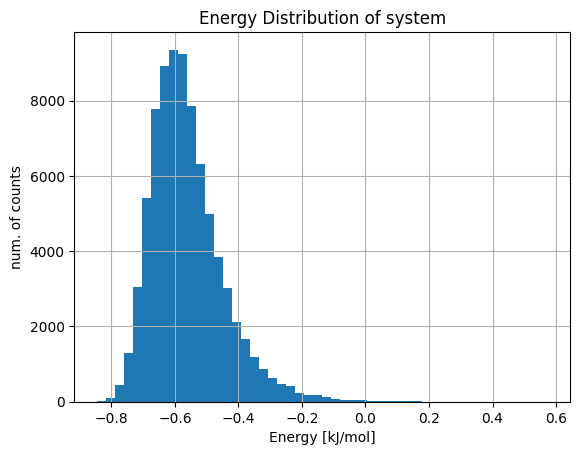

In [ ]:


plt.title("Energy Distribution of system")
plt.hist(np.sum(e[20000:],axis=1)/N,bins=n_bins,density=False)
plt.grid(True)
plt.xlabel("Energy [kJ/mol]")
plt.ylabel("num. of counts")
plt.savefig("e5-20000_time-energy-system-histogram.png")
plt.show()
plt.close()

In [ ]:
def rdf(relative_distnace, bin_size, box):
    """
    Calculates the radial distribution function from a dataset.

    Parameters:
        relative_distnace: (np.ndarray)
            -> all relative distances of a simulation run.
       
        data: (np.ndarray)
            -> Simulation data of shape (T, dim, n_particles)

        n_bins: (int)
            -> Number of bins for the RDF histogram.

    Returns:
        tuple: (rdf_values, bin_edges)
            rdf_values: Radial distribution function values.
            bin_edges: The edges of the RDF bins (r values).
    """
    print("data shape",relative_distnace.shape)
    T, n_particles, _ = relative_distnace.shape
    box_size_x, box_size_y = box[0], box[1]
    rho = n_particles / (box_size_x * box_size_y)  # Isotropic density in 2D
    max_distance = box_size_x/2 # np.sqrt((box_size_x/2)**2+(box_size_y/2)**2)
    n_bins= int(np.ceil(max_distance/bin_size))
    print("number of bins:",n_bins)
    bin_edges = np.linspace(0, max_distance, n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    print("length of bin-array:",len(bin_centers))
    rdf_hist=np.zeros((n_bins,))
    print("shape rdf_hist",rdf_hist.shape)
    print("shape of bin-array",bin_centers.shape)
    print("shape bin_edges-array",bin_edges.shape)
    hist, _ = np.histogram(relative_distnace, bins=bin_edges)
    rdf_hist+=hist
    # Normalize RDF
    two_pi_r = 2 * np.pi * bin_edges[1:]
    dn_dr = rdf_hist/bin_size
    rdf_values = dn_dr / (T * n_particles * two_pi_r * rho)
    return rdf_values, bin_centers

data shape (100000, 25, 24)
number of bins: 250
length of bin-array: 250
shape rdf_hist (250,)
shape of bin-array (250,)
shape bin_edges-array (251,)
data shape (80000, 25, 24)
number of bins: 250
length of bin-array: 250
shape rdf_hist (250,)
shape of bin-array (250,)
shape bin_edges-array (251,)
data shape (50000, 25, 24)
number of bins: 250
length of bin-array: 250
shape rdf_hist (250,)
shape of bin-array (250,)
shape bin_edges-array (251,)


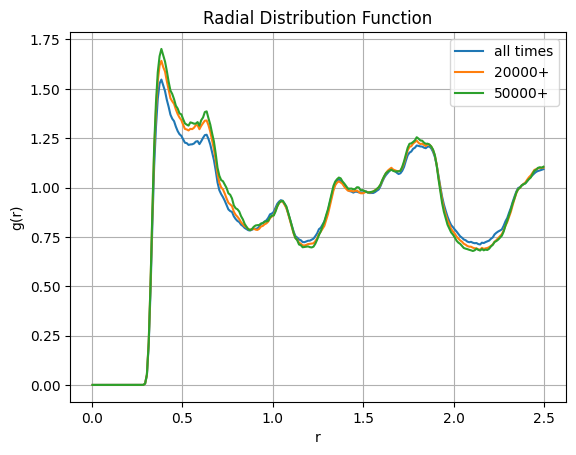

In [ ]:
rdf1,bin1=rdf(relative_distnace=collect_distances[:],bin_size=0.01,box=B)

rdf2,bin2=rdf(relative_distnace=collect_distances[20000:],bin_size=0.01,box=B)

rdf3,bin3=rdf(relative_distnace=collect_distances[50000:],bin_size=0.01,box=B)

plt.plot(bin1, rdf1,label="all times")
plt.plot(bin2, rdf2, label="20000+")
plt.plot(bin3, rdf3, label="50000+")
plt.legend()
plt.title("Radial Distribution Function")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.grid(True)
plt.savefig("rdf.png")
plt.show()
plt.close()

In [ ]:
def animate(
        frame,
        data: NDArray[np.float64], 
        scat
):
    """
    Takes x and y data [time, particle]; init funciton for "creat_animation"
    """
    scat.set_offsets(np.c_[data[frame,:,0],data[frame,:,1]])
    return scat,

def animation_plot(
    p_radius: float|int,
    box: tuple[float|int]
):
    """
    takes box size and particle radius. Initation for "creat_animation"
    """
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], s=p_radius)  # Scale size for visibility
    ax.set_xlim(0,box[0])
    ax.set_ylim(0,box[1])
    ax.set_title("Simulation Visualization")
    ax.set_xlabel("X [nm]")
    ax.set_ylabel("Y [nm]")
    plt.grid(True,which="both")
    return scat, fig, ax

def creat_animation(
        animation_box: tuple[int,int],
        particle_drawn_radius: float|int,
        data: NDArray[np.float64],
        save_animation: bool= False,
        animation_name: str= "partilce_simulation",
) -> FuncAnimation: 
    """
    Creats animation for x and y data
    
    Parameters:

        animation_box: (tuple)
            -> simulation box

        particle_drawn_radius: (number)
            -> how big the particles should be drawn

        data: (NDArray[float, shape=(T, dim, num)]) 

    """
    scat, fig, ax = animation_plot(p_radius=particle_drawn_radius, box=animation_box)
    anim = FuncAnimation(fig, 
                        func=animate,
                        frames=len(data[:,0,0]),
                        fargs=(data, scat),
                        interval=10,
                        blit=False
                    )
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Dominic Nieder'), bitrate=1800)
    if save_animation:
        anim.save(animation_name+".mp4")
    return anim

In [ ]:
mp4=creat_animation(animation_box=B, data=collect_positions,particle_drawn_radius=20,save_animation=True,animation_name="MC-animation")
HTML(mp4.to_html5_video())